# Importing Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import joblib

# 1. Loading Dataset

In [4]:
data = pd.read_csv('../Dataset/StudentPlacement.csv')
data.head()

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons,Skill 1,Skill 2,Profile
0,49,22,41,26,7,28,61,1,8,3,Javascript,Photoshop,UI/UX
1,39,46,45,47,3,35,65,4,10,4,HTML/CSS,GitHub,UI/UX
2,28,32,45,35,10,23,85,3,10,3,Photoshop,Figma,UI/UX
3,52,38,33,38,19,27,62,1,9,3,Photoshop,Figma,UI/UX
4,23,31,30,38,10,13,72,4,8,5,HTML/CSS,Figma,UI/UX


## 1.1. Dataset Dictionary Explanation

#### Columns:
- DSA: Score of Student in DSA subject out of 100
- DBMS: Score of Student in DBMS subject out of 100 
- OS: Score of Student in OS subject out of 100
- CN: Score of Student in CN subject out of 100
- Mathmetics: Score of Student in mathmetics subject out of 100
- Aptitute: Score of Student in aptitute out of 100
- Comm: Score of student in Comm out of 100
- Problem Solving: Score of student in Problem solving out of 10
- Creative: Score of Student in creative skills out of 10
- Hackathons: How many hackathons does the student particpated
- Skill 1: top 1 skill the student is good at (Categorical)
- Skill 2: Top 2nd skill that student is good at. (Categorical)
- Profile: The student prefered role based on the skills and score - target variable (categorical)

In [3]:
# shape of the dataset
data.shape

(707, 13)

In [4]:
# basic info of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DSA              707 non-null    int64 
 1   DBMS             707 non-null    int64 
 2   OS               707 non-null    int64 
 3   CN               707 non-null    int64 
 4   Mathmetics       707 non-null    int64 
 5   Aptitute         707 non-null    int64 
 6   Comm             707 non-null    int64 
 7   Problem Solving  707 non-null    int64 
 8   Creative         707 non-null    int64 
 9   Hackathons       707 non-null    int64 
 10  Skill 1          707 non-null    object
 11  Skill 2          707 non-null    object
 12  Profile          707 non-null    object
dtypes: int64(10), object(3)
memory usage: 71.9+ KB


- Every column is having correct datatypes and we have 13 columns where Profile feature the target variable

In [5]:
# checking for any null values
data.isnull().sum()

DSA                0
DBMS               0
OS                 0
CN                 0
Mathmetics         0
Aptitute           0
Comm               0
Problem Solving    0
Creative           0
Hackathons         0
Skill 1            0
Skill 2            0
Profile            0
dtype: int64

- There are no null values in the dataset 

In [6]:
# checking for any duplicate values in the dataset
data[data.duplicated(data.columns[:-1])]

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons,Skill 1,Skill 2,Profile


- We can see that there are 0 duplicated values in the dataset

In [7]:
#  viewing the unique profiles that this dataset have
data["Profile"].unique()

array(['UI/UX', 'Web Developer', 'DATA Scientist', 'Software Engineer',
       'Database Administrator', 'Network Engineer', 'Tech Support'],
      dtype=object)

- This dataset contains the following profiles as target varibale 'UI/UX', 'Web Developer', 'DATA Scientist', 'Software Engineer',
       'Database Administrator', 'Network Engineer', 'Tech Support'

In [5]:
# Extracting the numerical and categorical features
numerical_data = data.select_dtypes(include=['number'])
categorical_data = data.select_dtypes(include=['object', 'category'])

In [6]:
# getting the numerical and categorical columns
numerical_cols = numerical_data.columns
categorical_cols = categorical_data.columns

In [7]:
# no of unique values does each numberical feature haves
numerical_data.nunique() 

DSA                94
DBMS               95
OS                 90
CN                 96
Mathmetics         99
Aptitute           86
Comm               51
Problem Solving    10
Creative            9
Hackathons         11
dtype: int64

# 2. EDA

## 2.1. EDA on Numerical Data

### 2.1.1. Understanding the co-relations

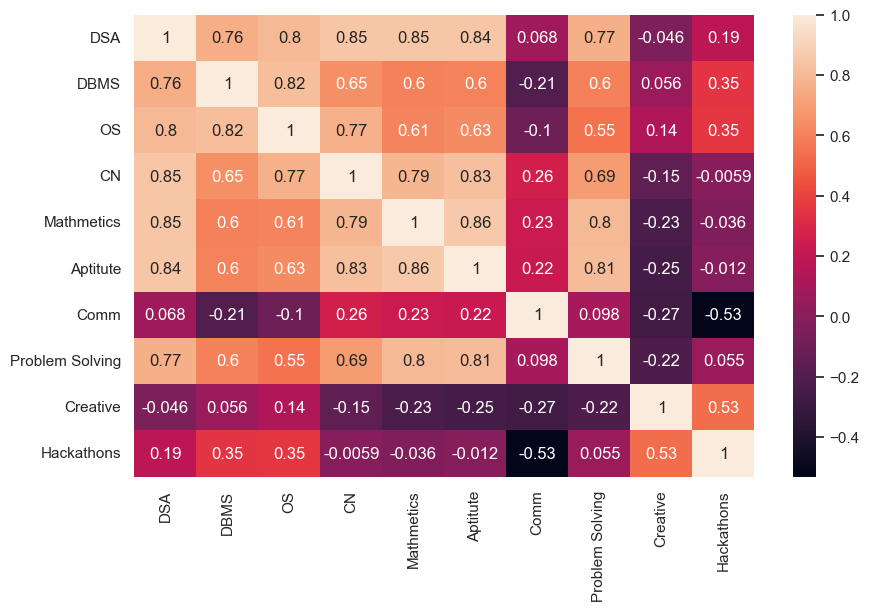

In [8]:
# seeing the 

# Set the figure size
sns.set(rc={'figure.figsize':(10, 6)})  # width=10, height=6

sns.heatmap(numerical_data.corr(), annot = True)
plt.show()

### 2.1.2. Distribution of the numerical features 

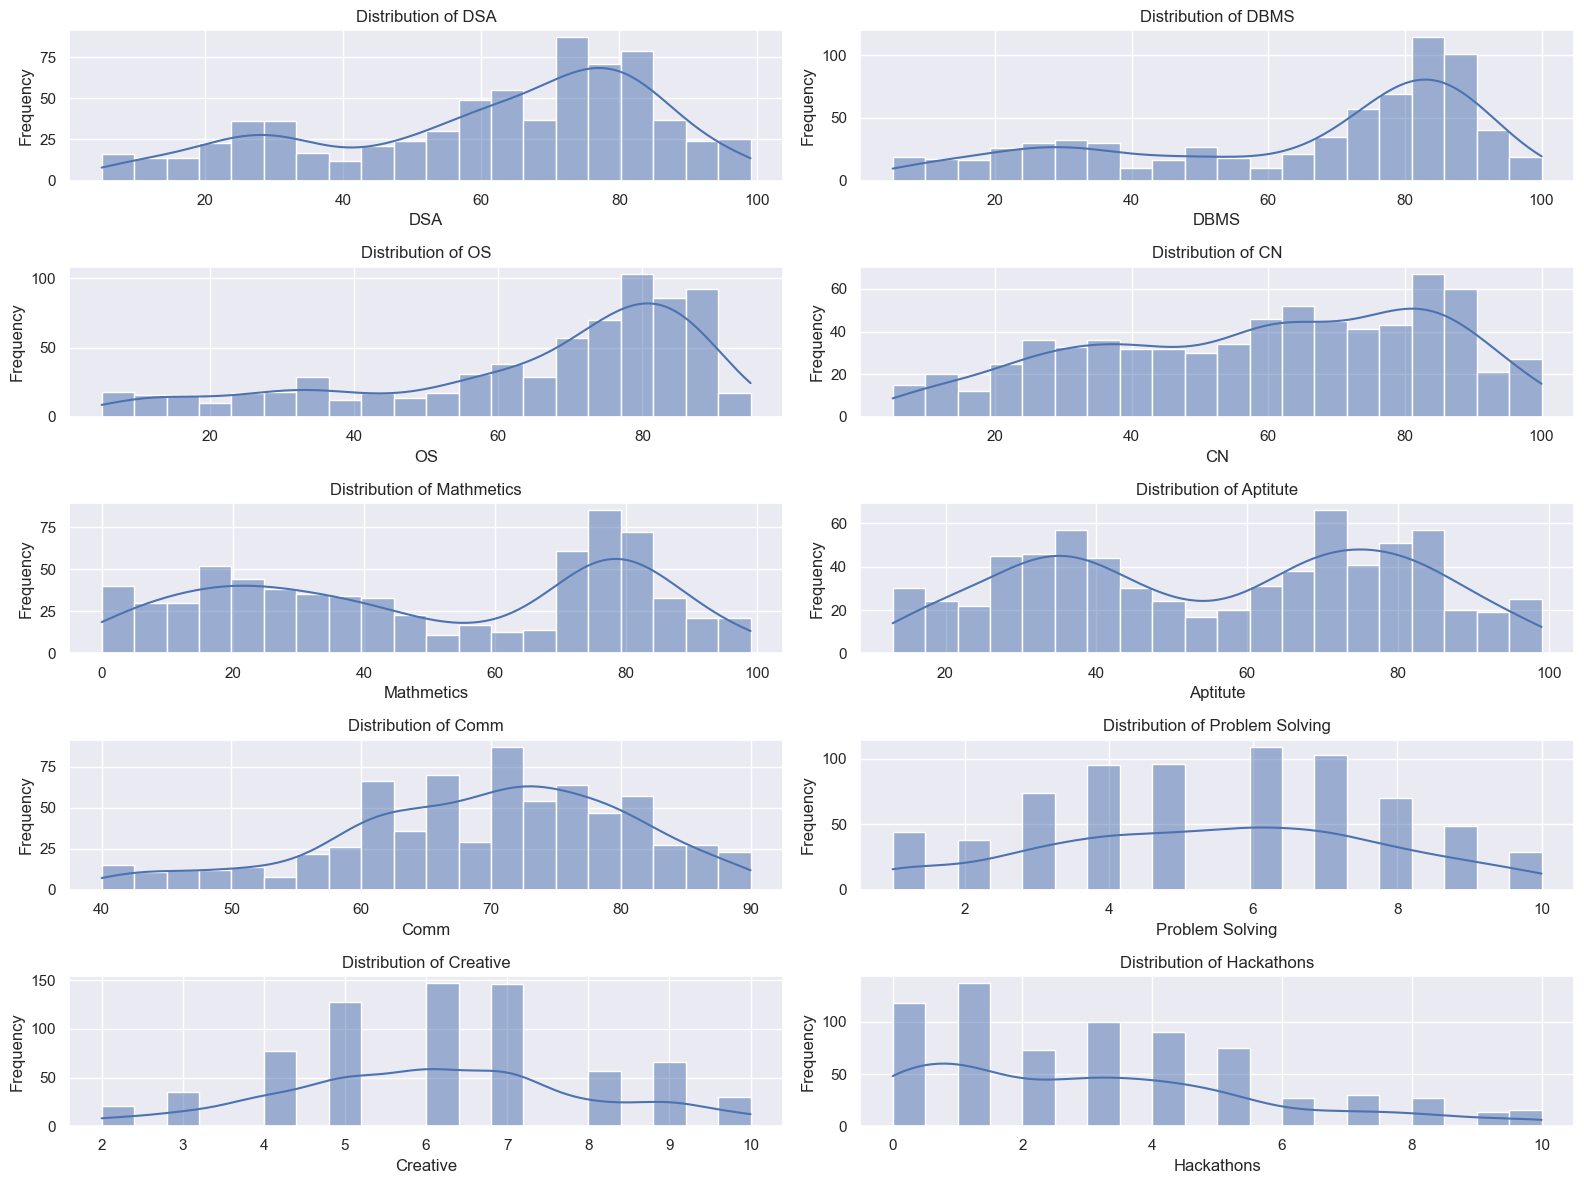

In [9]:
# Set plot size
plt.figure(figsize=(16, 12))

# Loop through each numerical column and plot the distribution
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 2, i)
    sns.histplot(data[col], kde=True, bins=20)  # Histogram with kernel density estimate (KDE)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 2.1.3. Box Plot Visualization 

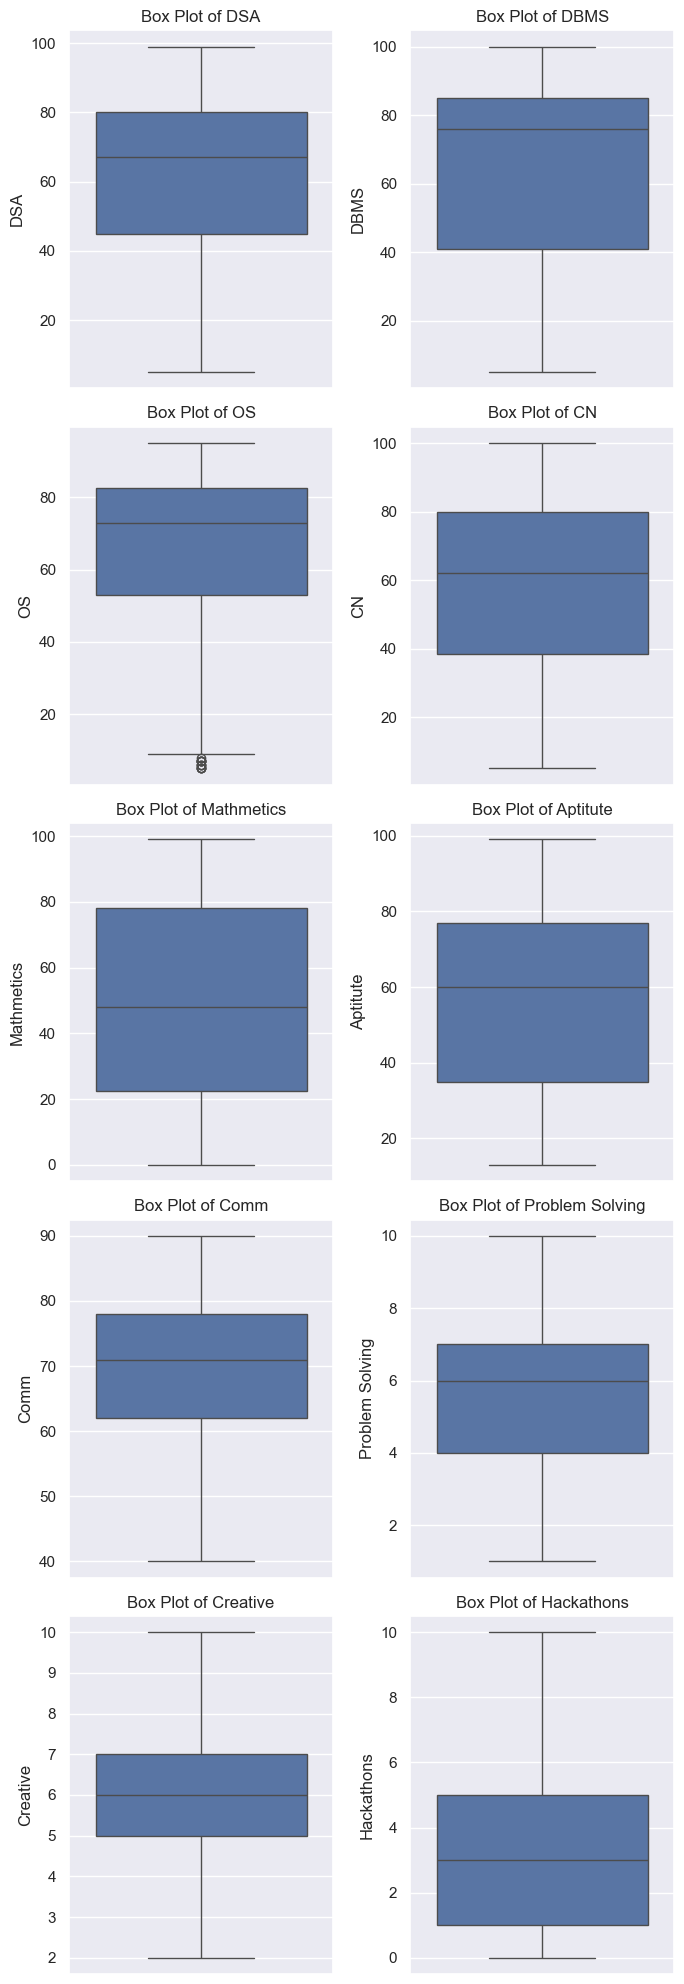

In [10]:
# Set plot size
plt.figure(figsize=(7, 20))

# Loop through each numerical column and plot a box plot
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(y=data[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

#### 2.1.3.1. Removing Outliers Using IQR

In [11]:
# Function to remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Remove outliers from the numerical columns
cleaned_data = remove_outliers(data.copy(), numerical_cols)

### 2.1.4. Percentage of profile job roles
- Checking the percentage of jobs that we have in the dataset

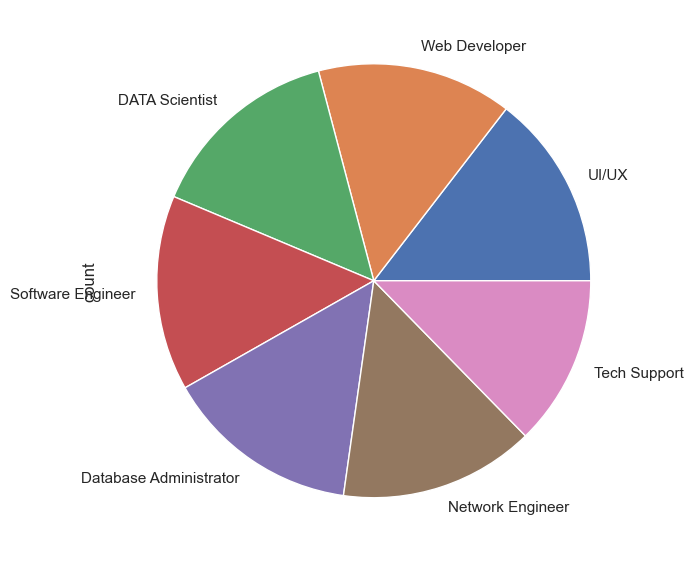

In [12]:
# Set plot size
plt.figure(figsize=(7, 20))

cleaned_data['Profile'].value_counts().plot.pie()
plt.show()

- We can see from the pie chart that mostly all of them have same percentage of distribution in the dataset

# 3. Data Preprocessing

## 3.1. Skills Column encoding
- We can see that Skill 1 and Skill 2 column have categorical values and needed to encode them 

In [13]:
# Seeing weather the skill 1 and skill 2 column have same unique skills or not
skill1_values = sorted(cleaned_data["Skill 1"].unique())
skill2_values = sorted(cleaned_data['Skill 2'].unique())

print(skill1_values == skill2_values)

True


In [14]:
skill1_values

['Angular',
 'Ansible',
 'BASH/SHELL',
 'C/C++',
 'Cisco Packet tracer',
 'Deep Learning',
 'Figma',
 'GitHub',
 'HTML/CSS',
 'Java',
 'Javascript',
 'Linux',
 'MYSQL',
 'Machine Learning',
 'Node.js',
 'Oracle',
 'Photoshop',
 'Python',
 'Pytorch',
 'R',
 'React',
 'Tensorflow',
 'Wire Shark']

- "True" indicates that the column skill 1 and skill 2 of the dataset have same values, so we can use the same labelEncoder for the columns to encode and we can use the same for the decoder of the skills columns

In [15]:
# Label encoding the Skill 1 and Skill 2 columns
skill_encoder = LabelEncoder()
cleaned_data['Skill 1'] = skill_encoder.fit_transform(cleaned_data['Skill 1'])
cleaned_data['Skill 2'] = skill_encoder.transform(cleaned_data['Skill 2'])


cleaned_data.head()

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons,Skill 1,Skill 2,Profile
0,49,22,41,26,7,28,61,1,8,3,10,16,UI/UX
1,39,46,45,47,3,35,65,4,10,4,8,7,UI/UX
2,28,32,45,35,10,23,85,3,10,3,16,6,UI/UX
3,52,38,33,38,19,27,62,1,9,3,16,6,UI/UX
4,23,31,30,38,10,13,72,4,8,5,8,6,UI/UX


In [16]:
skill_encoder.inverse_transform([2])

array(['BASH/SHELL'], dtype=object)

## 3.2. Profile Column encoding
- Profile feature is our target variable and needed to encode in order make it trainable ready

In [17]:
cleaned_data["Profile"].unique()

array(['UI/UX', 'Web Developer', 'DATA Scientist', 'Software Engineer',
       'Database Administrator', 'Network Engineer', 'Tech Support'],
      dtype=object)

In [18]:
profile_encoder = LabelEncoder()
cleaned_data['Profile'] = profile_encoder.fit_transform(cleaned_data['Profile'])

cleaned_data.head()

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons,Skill 1,Skill 2,Profile
0,49,22,41,26,7,28,61,1,8,3,10,16,5
1,39,46,45,47,3,35,65,4,10,4,8,7,5
2,28,32,45,35,10,23,85,3,10,3,16,6,5
3,52,38,33,38,19,27,62,1,9,3,16,6,5
4,23,31,30,38,10,13,72,4,8,5,8,6,5


## 3.3. Train Test Split
- Dividing the dataset into train and test datasets

In [19]:
X = cleaned_data.drop(columns=['Profile'], axis=1)
y = cleaned_data['Profile']

#### 3.3.1 StandardScaler on numerical features

In [20]:
# Create a StandardScaler object
# scaler = StandardScaler()

# Fit the scaler to the numerical features and transform the data
# X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [21]:
X.head()

,DSA,DBMS,OS,CN,Mathmetics,Aptitute,Comm,Problem Solving,Creative,Hackathons,Skill 1,Skill 2
0,49,22,41,26,7,28,61,1,8,3,10,16
1,39,46,45,47,3,35,65,4,10,4,8,7
2,28,32,45,35,10,23,85,3,10,3,16,6
3,52,38,33,38,19,27,62,1,9,3,16,6
4,23,31,30,38,10,13,72,4,8,5,8,6


In [22]:
y[:10]

0    5
1    5
2    5
3    5
4    5
5    5
6    5
7    5
8    5
9    5
Name: Profile, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2, stratify=y)

# 4. Model Training

### Explanation:

1. **Hyperparameter Spaces**: Each model has a predefined set of hyperparameters:
   - **LR (Logistic Regression)**: We tune `C`, `penalty`, and `solver`.
   - **SVC (Support Vector Classifier)**: We tune `C`, `gamma`, and `kernel`.
   - **DT (Decision Tree)**: We tune `max_depth`, `min_samples_split`, `min_samples_leaf`, and `criterion`.
   - **RF (Random Forest)**: We tune `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `bootstrap`.
   - **GBC (Gradient Boosting Classifier)**: We tune `n_estimators`, `learning_rate`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `subsample`.

2. **BayesSearchCV**:
   - The `BayesSearchCV` is initialized for each model with its hyperparameter search space, cross-validation folds (5), and the number of optimization iterations (32).
   - The `random_state=42` ensures reproducibility.

3. **Best Models**:
   - The function returns a dictionary `best_models` where the keys are model names (`LR`, `SVC`, etc.) and the values are the models with the best hyperparameters found by `BayesSearchCV`.

4. **Cross-Validation**: Uses 5-fold cross-validation (`cv=5`) to validate the model during hyperparameter search.


In [24]:
# Function to perform Bayesian Optimization with BayesSearchCV for multiple models
def optimize_models(X_train, y_train):
    
    # Define hyperparameter spaces for each model
    param_spaces = {
        'LR': {
            'C': Real(1e-6, 1e+6, prior='log-uniform'),
            'penalty': Categorical(['l2']),
            'solver': Categorical(['lbfgs', 'newton-cg', 'liblinear']),
        },
        'SVC': {
            'C': Real(1e-6, 1e+3, prior='log-uniform'),
            'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
            'kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid']),
        },
        'DT': {
            'max_depth': Integer(1, 30),
            'min_samples_split': Integer(2, 10),
            'min_samples_leaf': Integer(1, 10),
            'criterion': Categorical(['gini', 'entropy']),
        },
        'RF': {
            'n_estimators': Integer(10, 200),
            'max_depth': Integer(1, 30),
            'min_samples_split': Integer(2, 10),
            'min_samples_leaf': Integer(1, 10),
            'bootstrap': Categorical([True, False]),
        }
    }
    
    # Models dictionary
    models = {
        'LR': LogisticRegression(max_iter=1000),
        'SVC': SVC(),
        'DT': DecisionTreeClassifier(),
        'RF': RandomForestClassifier(),
    }

    # Dictionary to store the best-trained models
    best_models = {}

    # Perform Bayesian Optimization for each model
    for model_name in models:
        print(f"Optimizing {model_name}...")
        
        # Initialize BayesSearchCV
        opt = BayesSearchCV(
            models[model_name], 
            param_spaces[model_name], 
            n_iter=32,      # Number of iterations for optimization
            cv=5,           # 5-fold cross-validation
            n_jobs=-1,      # Use all available cores
            verbose=0,
            random_state=42
        )
        
        # Fit the BayesSearchCV on the training data
        opt.fit(X_train, y_train)
        
        # Store the best model found
        best_models[model_name] = opt.best_estimator_
        print(f"Best parameters for {model_name}: {opt.best_params_}")
        print(f"Best score for {model_name}: {opt.best_score_}\n")
    
    return best_models


# training each model on X_train and y_train data
best_models = optimize_models(X_train, y_train) 

## 4.1. GridSearchCV

In [26]:
# Function to perform hyperparameter tuning with GridSearchCV for multiple models
def optimize_models_grid(X_train, y_train):
    
    # Define hyperparameter spaces for each model
    param_spaces = {
        'LR': {
            'C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1e6],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg', 'liblinear'],
        },
        'SVC': {
            'C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 1000],
            'gamma': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        },
        'DT': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 12, 15, 17, 20],
            'min_samples_split': [2, 5, 10, 12, 15],
            'max_leaf_nodes': [None, 20, 25, 30, 35, 40],
            'min_samples_leaf': [1, 2, 5, 7, 10],
        },
        'RF': {
            'n_estimators': [10, 50, 100, 150, 200],
            'max_depth': [None, 1, 5, 10, 15, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5, 7, 10],
            'bootstrap': [True, False],
        }
    }
    
    # Models dictionary
    models = {
        'LR': LogisticRegression(max_iter=1000),
        'SVC': SVC(),
        'DT': DecisionTreeClassifier(random_state=42),
        'RF': RandomForestClassifier(),
    }

    # Dictionary to store the best-trained models
    best_models = {}

    # Perform Grid Search for each model
    for model_name in models:
        print(f"Optimizing {model_name}...")
        
        # Initialize GridSearchCV
        grid_search = GridSearchCV(estimator=models[model_name], param_grid=param_spaces[model_name], 
                                   cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        
        # Fit the GridSearchCV on the training data
        grid_search.fit(X_train, y_train)
        
        # Store the best model found
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}\n")
    
    return best_models


# training each model on X_train and y_train data
best_models_grid = optimize_models_grid(X_train, y_train) 

## 4.2. Learning Curve

### Step-by-Step Instructions:

1. **Use `learning_curve`**:
   - The function takes a model, the dataset, and parameters like the cross-validation strategy and scoring metric.
   - It will return the training and validation scores across different training sizes.

2. **Plot the learning curve**:
   - You can use `matplotlib` to plot the learning curve, which will show the training score and validation score as a function of the number of training samples.

### Key Components:

1. **`learning_curve` Function**:
   - **`estimator`**: The model for which you want to generate the learning curve (e.g., Logistic Regression, SVC, etc.).
   - **`X_train`, `y_train`**: Your training data.
   - **`cv`**: Cross-validation strategy (default 5-fold).
   - **`scoring`**: The evaluation metric (e.g., accuracy, f1, precision, etc.).
   - **`train_sizes`**: A sequence of values that defines the proportions of the training set to use (here it's between 10% and 100%).

2. **Plotting**:
   - The training and validation (cross-validation) scores are plotted with a confidence interval (standard deviation).

3. **Example Usage**:
   - The function `plot_learning_curve` is called for each model stored in `best_models` (e.g., Logistic Regression, SVC, etc.) after Bayesian Optimization.
   
### Output:
- **Training Score**: Shows how well the model fits the training data as the size of the training set increases.
- **Validation Score**: Shows how well the model generalizes to unseen data.
  


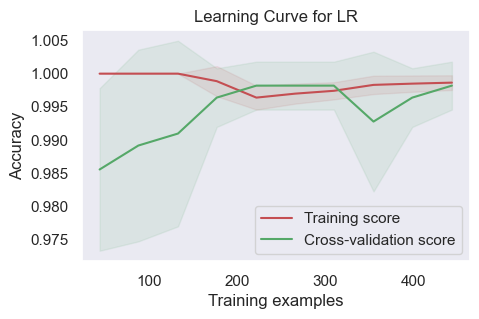

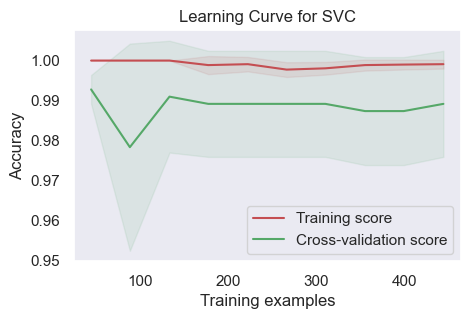

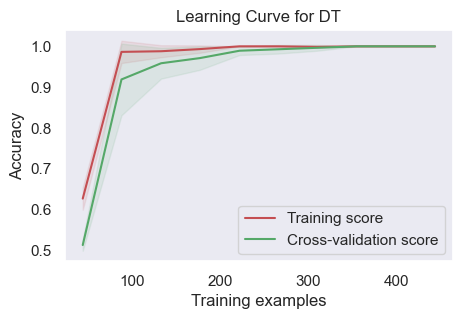

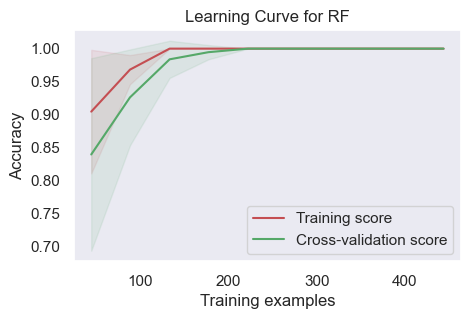

In [34]:
def plot_learning_curve(estimator, X_train, y_train, title, cv=5, scoring='accuracy'):
    """Plots a learning curve for a given model."""
    
    # Generate learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, n_jobs=-1, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(5, 3))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel(scoring.capitalize())
    
    # Plot the training score curve
    plt.plot(train_sizes, train_scores_mean, label="Training score", color="r")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, color="r", alpha=0.1)
    
    # Plot the validation score curve
    plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="g")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, color="g", alpha=0.1)
    
    plt.legend(loc="best")
    plt.grid()
    plt.show()


# Plot learning curves for each model
for model_name, model in best_models.items():
    plot_learning_curve(model, X_train, y_train, f"Learning Curve for {model_name}")

/Users/jaswanth/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jaswanth/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

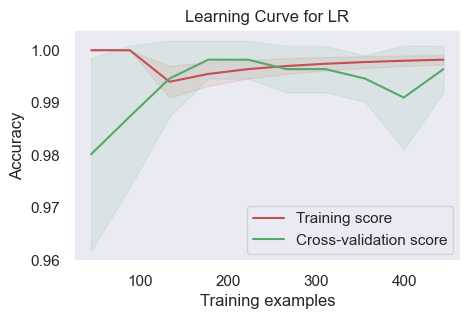

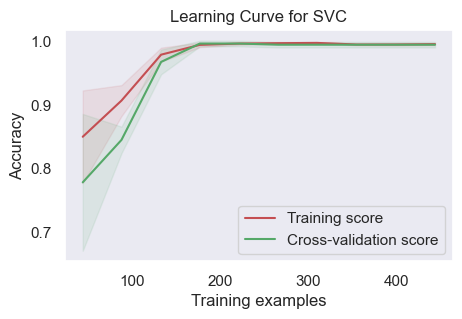

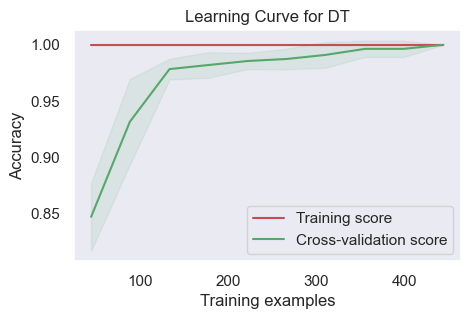

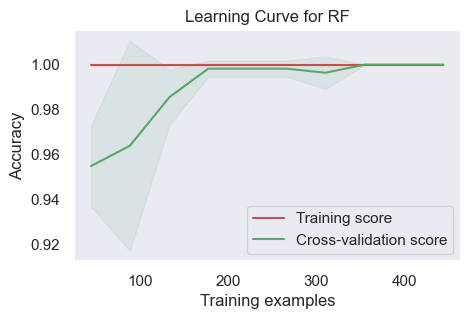

In [36]:
# Plot learning curves for each model
for model_name, model in best_models_grid.items():
    plot_learning_curve(model, X_train, y_train, f"Learning Curve for {model_name}")

In [30]:
# Model evaluations
def evaluate_models_on_test(best_models, X_test, y_test):
    """Evaluates each model in the best_models dictionary on the test dataset and prints the test score."""
    
    test_scores = {}
    
    # Loop through each model and compute its test score
    for model_name, model in best_models.items():
        # Get predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate the accuracy score (or you can use another metric like f1_score, precision, etc.)
        score = accuracy_score(y_test, y_pred)
        
        # Store the score in the dictionary
        test_scores[model_name] = score

        print(f"Classification Report of {model_name}: \n\n{classification_report(y_test, y_pred)}\n")
        
        # Print the test score for the model
        print(f"{model_name} Test Accuracy: {score:.2f}\n\n")
    
    return test_scores


# testing the data on best trained models 
test_scores = evaluate_models_on_test(best_models, X_test, y_test)

# 5. Model Saving

In [38]:
# Function to evaluate models and save them with their test accuracy
def evaluate_and_save_models(best_models, X_test, y_test):
    # Ensure the save directory exists
    save_dir = "../Models/"
    os.makedirs(save_dir, exist_ok=True)
    
    for model_name, model in best_models.items():
        y_pred = model.predict(X_test)  # Predict on test data
        accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
        
        # Convert accuracy to an integer percentage (e.g., 0.93 becomes 93)
        accuracy_percentage = int(accuracy * 100)
        
        # Save the model with the formatted accuracy in the filename
        model_filename = os.path.join(save_dir, f"{model_name}_accuracy_{accuracy_percentage}.joblib")
        joblib.dump((model, skill_encoder, profile_encoder ), model_filename)
        
        print(f"{model_name} Test Accuracy: {accuracy_percentage}%")


# Evaluate and save models
evaluate_and_save_models(best_models, X_test, y_test)

LR Test Accuracy: 99%
SVC Test Accuracy: 100%
DT Test Accuracy: 100%
RF Test Accuracy: 100%
